# Train Classifier For News Classification
> ## * fastText

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os
from glob import glob

from numba import jit

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import FastText, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,  accuracy_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import xgboost as xgb

import matplotlib.pyplot as plt


import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9066578436634670257
]


In [3]:
import Basic_Module as bm

In [4]:
cores = multiprocessing.cpu_count()
print (cores)

4


## Document Labeling

In [5]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags category')

> * words : 기사에서 나온 단어들 or keywords
> * tags : 문서 tag
> * classes : category
>> 기사분류가 daum보다 naver에서 더 세분화되어 있기 때문에 네이버의 category 분류를 이용하기로 함

## Category

In [6]:
if os.path.isfile('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_fastText_news_classification.pickled'):
    le = pickle.load(open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_fastText_news_classification.pickled','rb'))
else:
    le = LabelEncoder()
    le.fit(naverData['category'])
    pickle.dump(le, open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_fastText_news_classification.pickled','wb'))
print (le.classes_)

['IT/과학' '경제' '사회' '생활/문화' '세계' '스포츠' '연예' '정치']


In [7]:
if sys.platform =='darwin':
    loadModelPath = './news_model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/news_model/'
saveTrainPath = './data/pre_data/news_train_test_Data2/'
saveClassifierPath = './data/pre_data/news_classifier/'

## Tagging Twitter

> 전 단계에서 필요한 사전 데이터는 만들어 둠

### Train Data Set & Test Data Set

In [8]:
trainName = './data/pre_data/news_train_test_Data/pre_data_fastText_train_for_news_classification_by_ct.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_fastText_test_for_news_classification_by_ct.pickled'

In [9]:
if os.path.isfile(trainName) & os.path.isfile(testName):
    train = pickle.load(open(trainName, 'rb'))
    test = pickle.load(open(testName, 'rb'))
else:
    train, test = train_test_split(w2v_docs, test_size = 0.15)
    pickle.dump(train,open(trainName,'wb'))
    pickle.dump(test,open(testName,'wb'))

### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [10]:
tfidf = bm.Build_tfidf(train)

100%|██████████| 12852/12852 [00:00<00:00, 747945.71it/s]


(12852, 73912)
vocab size : 73912


In [11]:
x_train = [ x.words for x in tqdm(train)] 
y_train = np.array([ x.category for x in tqdm(train)])
x_test = [ x.words for x in tqdm(test)] 
y_test = np.array([ x.category for x in tqdm(test)])

100%|██████████| 2268/2268 [00:00<00:00, 906401.28it/s]


In [12]:
train_y2, test_y2 = bm.ReMake_Outcome(y_train, y_test)

100%|██████████| 2268/2268 [00:00<00:00, 625834.31it/s]


### Load Model

In [13]:
model1 = FastText.load(loadModelPath+'fastText_size-500_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-ct.model')
model2 = FastText.load(loadModelPath+'fastText_size-500_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-ct.model')
model3 = FastText.load(loadModelPath+'fastText_size-500_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-ct.model')

### model 1

In [14]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model1, tfidf, 500, train, test)
modelName = bm.Return_ModelName('fastText', model1,'ct')

  0%|          | 143/80610 [00:00<00:58, 1385.66it/s]

FastText(vocab=80610, size=500, alpha=0.025)


100%|██████████| 80610/80610 [00:02<00:00, 31239.72it/s]
0it [00:00, ?it/s]

running time : 0:00:02.605425
Vectorizing Train Data


12852it [04:18, 49.79it/s]


scaling Train Data


7it [00:00, 65.69it/s]

running time : 0:04:18.675098
Vectorizing Test Data


2268it [00:29, 75.83it/s]


scaling Test Data
running time : 0:00:29.966463
total running time : 0:04:51.246986


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [15]:
%%time
bm.Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 83822.21it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.651s...
[t-SNE] Computed neighbors for 10000 samples in 120.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.142124
[t-SNE] KL divergence after 250 iterations with early exaggeration: 152.880020
[t-SNE] Error after 1000 iterations: 4.254127


CPU times: user 13min 29s, sys: 48.9 s, total: 14min 18s
Wall time: 13min 29s


#### 분류모델 :  Logistic Regression

In [16]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.9078483245149912
classification report
             precision    recall  f1-score   support

          0       0.90      0.93      0.92       281
          1       0.85      0.85      0.85       272
          2       0.84      0.83      0.84       289
          3       0.88      0.90      0.89       271
          4       0.90      0.85      0.87       281
          5       0.97      0.99      0.98       282
          6       0.97      0.97      0.97       292
          7       0.93      0.94      0.94       300

avg / total       0.91      0.91      0.91      2268

CPU times: user 39.9 s, sys: 257 ms, total: 40.1 s
Wall time: 40.5 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

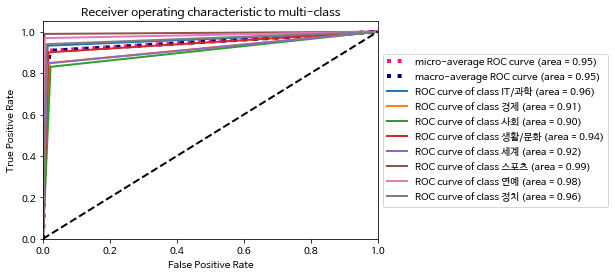

In [17]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

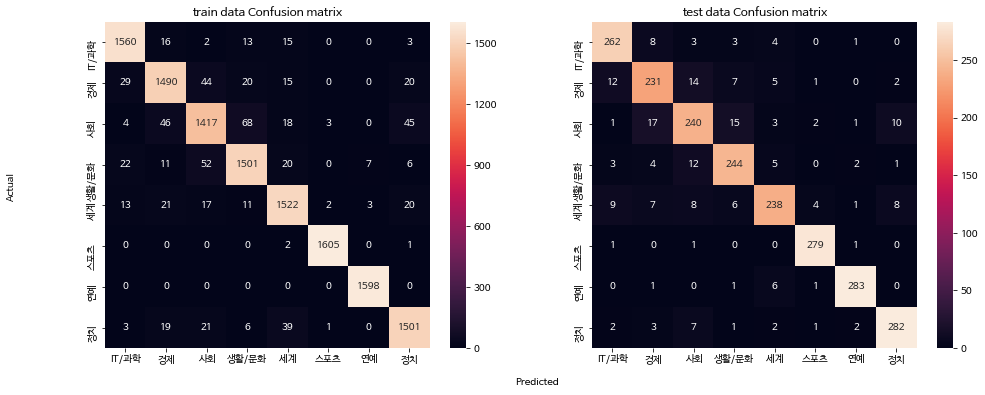

In [18]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [19]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8849206349206349
classification report
             precision    recall  f1-score   support

          0       0.89      0.93      0.91       281
          1       0.80      0.83      0.82       272
          2       0.82      0.79      0.80       289
          3       0.88      0.85      0.86       271
          4       0.89      0.81      0.85       281
          5       0.99      0.99      0.99       282
          6       0.94      0.97      0.95       292
          7       0.87      0.91      0.89       300

avg / total       0.88      0.88      0.88      2268

CPU times: user 32.1 s, sys: 300 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

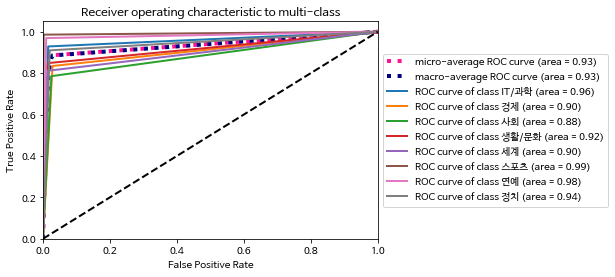

In [20]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

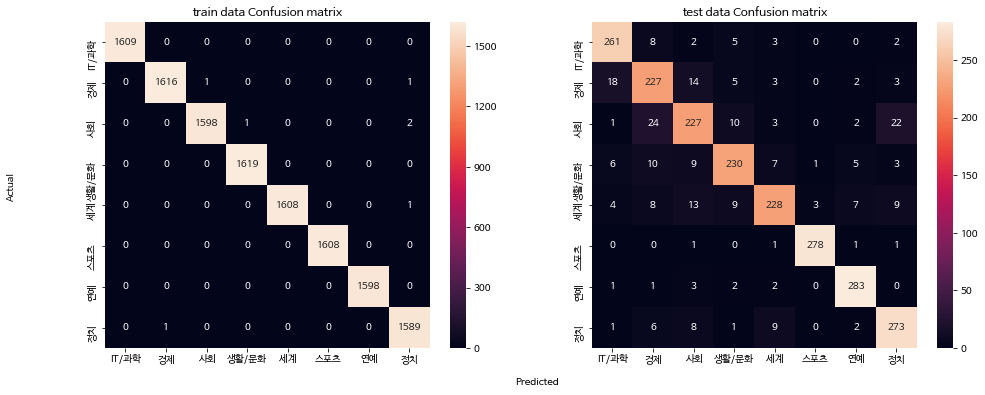

In [21]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [22]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9175485008818343
classification report
             precision    recall  f1-score   support

          0       0.92      0.96      0.94       281
          1       0.86      0.84      0.85       272
          2       0.88      0.83      0.85       289
          3       0.89      0.92      0.90       271
          4       0.90      0.89      0.90       281
          5       0.99      0.99      0.99       282
          6       0.97      0.96      0.96       292
          7       0.93      0.95      0.94       300

avg / total       0.92      0.92      0.92      2268

CPU times: user 1min 2s, sys: 174 ms, total: 1min 2s
Wall time: 1min 2s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

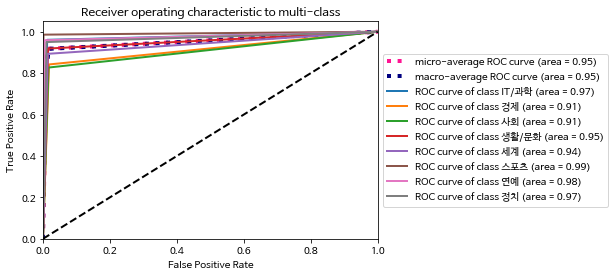

In [23]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

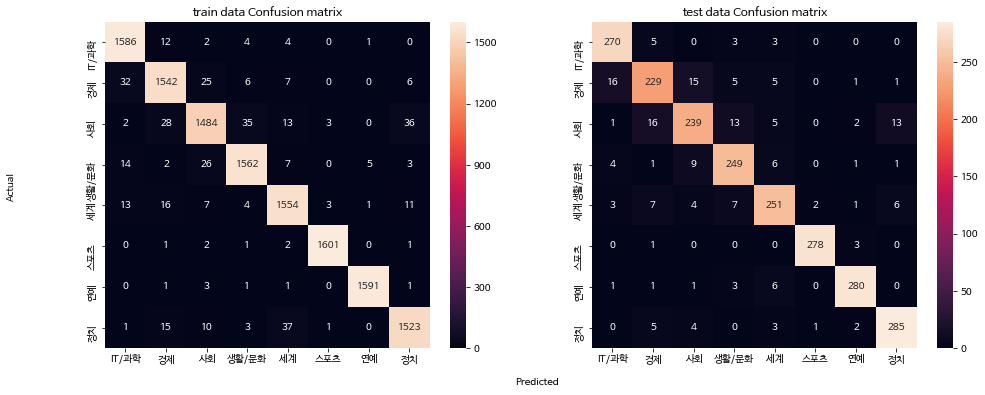

In [24]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [25]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 52.7 ms, sys: 32.7 ms, total: 85.3 ms
Wall time: 90.4 ms


In [26]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.78363	eval-mlogloss:1.81159
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.57852	eval-mlogloss:1.62946
[2]	train-mlogloss:1.42106	eval-mlogloss:1.4932
[3]	train-mlogloss:1.28729	eval-mlogloss:1.37567
[4]	train-mlogloss:1.17256	eval-mlogloss:1.27061
[5]	train-mlogloss:1.07183	eval-mlogloss:1.18117
[6]	train-mlogloss:0.987391	eval-mlogloss:1.10861
[7]	train-mlogloss:0.913575	eval-mlogloss:1.04505
[8]	train-mlogloss:0.846377	eval-mlogloss:0.984838
[9]	train-mlogloss:0.785569	eval-mlogloss:0.933021
[10]	train-mlogloss:0.732263	eval-mlogloss:0.888112
[11]	train-mlogloss:0.683224	eval-mlogloss:0.847503
[12]	train-mlogloss:0.638635	eval-mlogloss:0.808958
[13]	train-mlogloss:0.598932	eval-mlogloss:0.776231
[14]	train-mlogloss:0.563201	eval-mlogloss:0.743618
[15]	train-mlogloss:0.530331	eval-mlogloss:0.716193
[16]	train-mlogloss:0.499425	eval-mlogloss

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

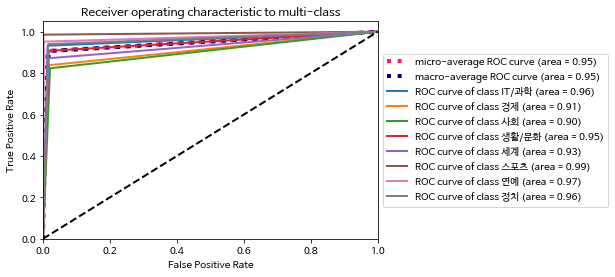

In [27]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

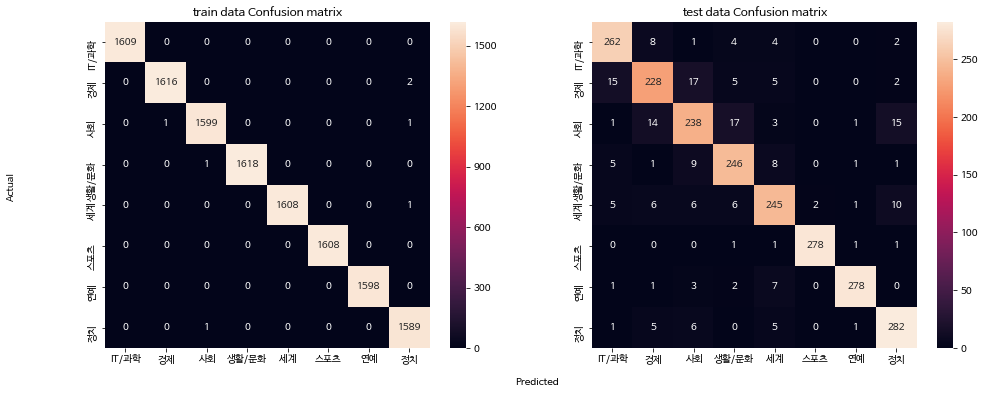

In [28]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

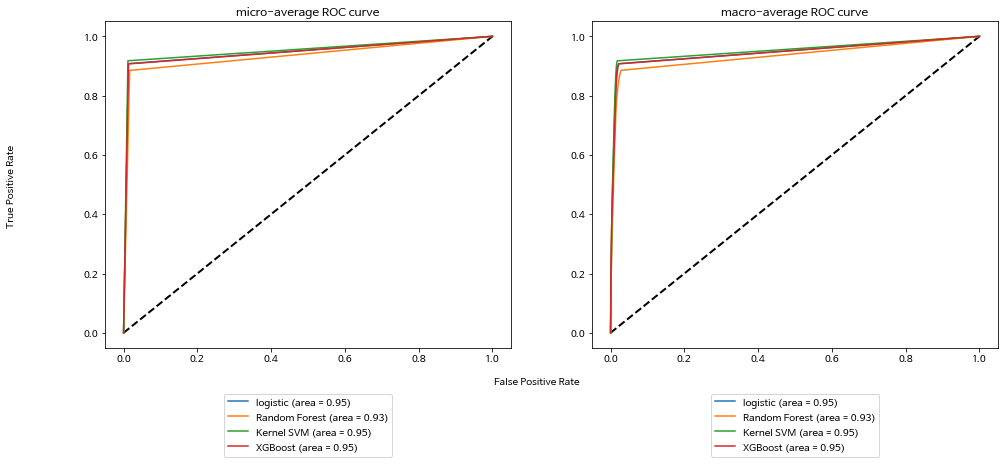

In [30]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [31]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5372
Accuracy: 0.9101


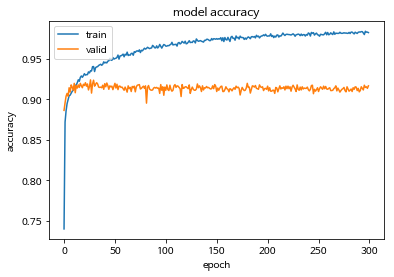

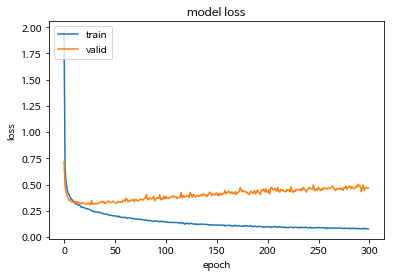

In [33]:
bm.plot_history(history)

In [34]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6939
Accuracy: 0.9061


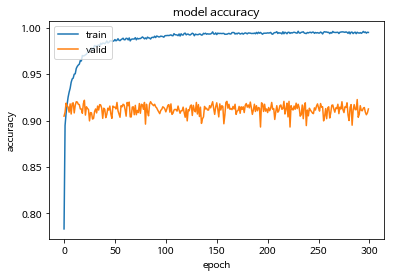

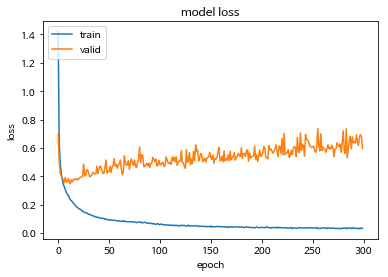

In [35]:
bm.plot_history(history)

### model 2

In [36]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model2, tfidf, 500, train, test)
modelName = bm.Return_ModelName('fastText', model2,'ct')

 13%|█▎        | 10699/80610 [00:00<00:00, 106962.05it/s]

FastText(vocab=80610, size=500, alpha=0.025)


100%|██████████| 80610/80610 [00:01<00:00, 76585.59it/s] 
1it [00:00,  6.44it/s]

running time : 0:00:01.059204
Vectorizing Train Data


12852it [02:56, 72.99it/s]


scaling Train Data


3it [00:00, 27.02it/s]

running time : 0:02:56.515847
Vectorizing Test Data


2268it [00:29, 77.35it/s]


scaling Test Data
running time : 0:00:29.396521
total running time : 0:03:26.971572


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [37]:
%%time
bm.Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 86707.72it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.411s...
[t-SNE] Computed neighbors for 10000 samples in 123.839s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.323659
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.757034
[t-SNE] Error after 1000 iterations: 2.579003


CPU times: user 10min 55s, sys: 56.6 s, total: 11min 52s
Wall time: 10min 20s


#### 분류모델 :  Logistic Regression

In [38]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.91005291005291
classification report
             precision    recall  f1-score   support

          0       0.90      0.96      0.93       281
          1       0.86      0.85      0.85       272
          2       0.87      0.80      0.84       289
          3       0.86      0.88      0.87       271
          4       0.90      0.87      0.88       281
          5       0.98      0.99      0.99       282
          6       0.97      0.97      0.97       292
          7       0.93      0.95      0.94       300

avg / total       0.91      0.91      0.91      2268

CPU times: user 1min 1s, sys: 342 ms, total: 1min 1s
Wall time: 1min 2s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

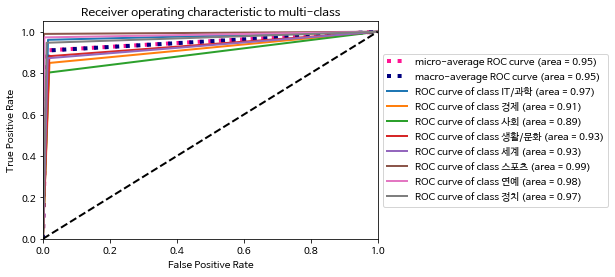

In [39]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

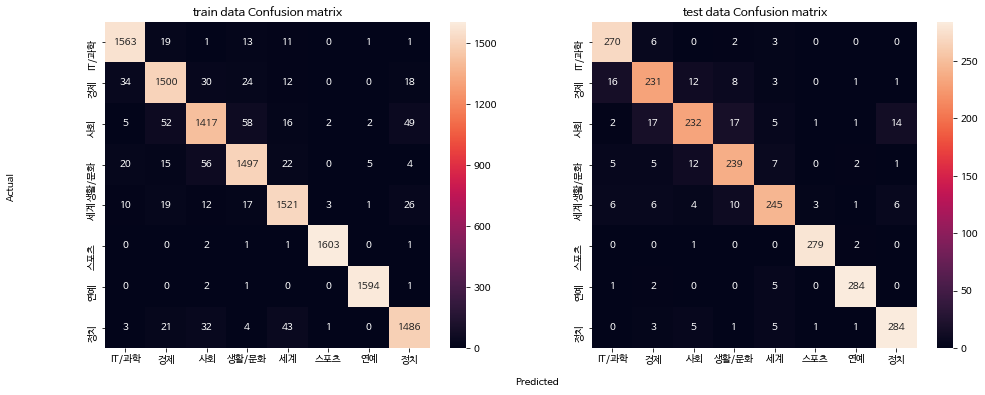

In [40]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [41]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8941798941798942
classification report
             precision    recall  f1-score   support

          0       0.91      0.95      0.93       281
          1       0.82      0.83      0.83       272
          2       0.85      0.80      0.82       289
          3       0.85      0.87      0.86       271
          4       0.89      0.81      0.85       281
          5       0.99      0.99      0.99       282
          6       0.97      0.97      0.97       292
          7       0.88      0.93      0.90       300

avg / total       0.89      0.89      0.89      2268

CPU times: user 34.6 s, sys: 189 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

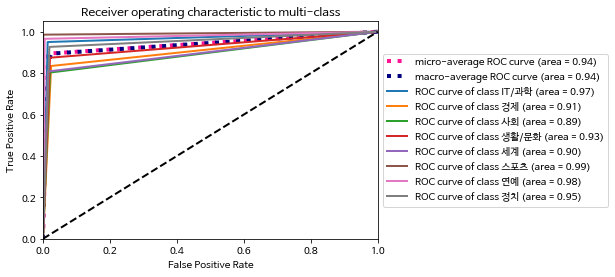

In [42]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

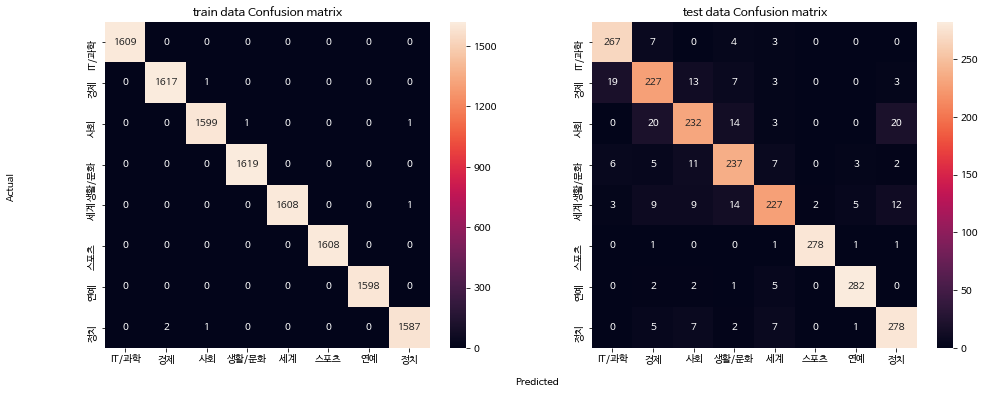

In [43]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [44]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9162257495590829
classification report
             precision    recall  f1-score   support

          0       0.91      0.96      0.94       281
          1       0.85      0.83      0.84       272
          2       0.87      0.83      0.85       289
          3       0.88      0.90      0.89       271
          4       0.92      0.88      0.90       281
          5       0.99      0.99      0.99       282
          6       0.98      0.98      0.98       292
          7       0.93      0.95      0.94       300

avg / total       0.92      0.92      0.92      2268

CPU times: user 39.7 s, sys: 99.6 ms, total: 39.8 s
Wall time: 39.8 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

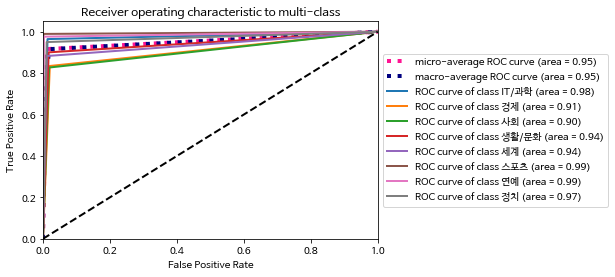

In [45]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

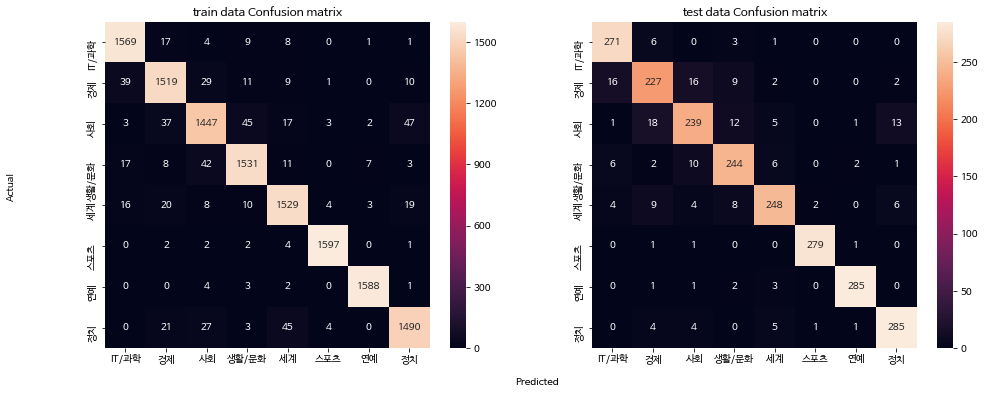

In [46]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [47]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 56.4 ms, sys: 35.7 ms, total: 92.1 ms
Wall time: 102 ms


In [48]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.64574	eval-mlogloss:1.66825
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.38313	eval-mlogloss:1.42152
[2]	train-mlogloss:1.19071	eval-mlogloss:1.24144
[3]	train-mlogloss:1.03982	eval-mlogloss:1.10482
[4]	train-mlogloss:0.919645	eval-mlogloss:0.994356
[5]	train-mlogloss:0.820153	eval-mlogloss:0.902744
[6]	train-mlogloss:0.736992	eval-mlogloss:0.826496
[7]	train-mlogloss:0.665602	eval-mlogloss:0.761173
[8]	train-mlogloss:0.605828	eval-mlogloss:0.708391
[9]	train-mlogloss:0.553126	eval-mlogloss:0.662319
[10]	train-mlogloss:0.505393	eval-mlogloss:0.621245
[11]	train-mlogloss:0.465054	eval-mlogloss:0.586897
[12]	train-mlogloss:0.428729	eval-mlogloss:0.555873
[13]	train-mlogloss:0.397312	eval-mlogloss:0.529392
[14]	train-mlogloss:0.369227	eval-mlogloss:0.505995
[15]	train-mlogloss:0.344074	eval-mlogloss:0.484741
[16]	train-mlogloss:0.321642	eval-m

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

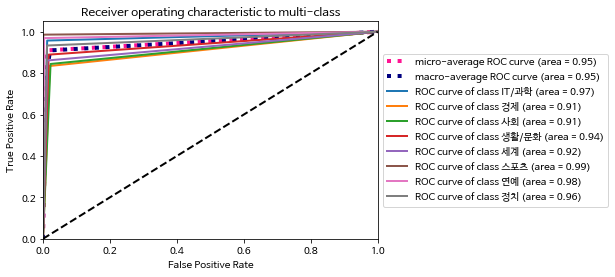

In [49]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

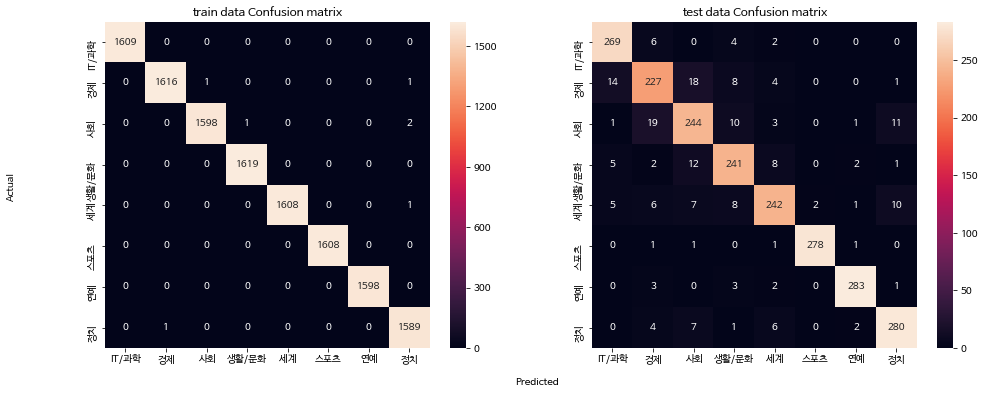

In [50]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [51]:
del classifier
del classifier2
del classifier3
del gbm

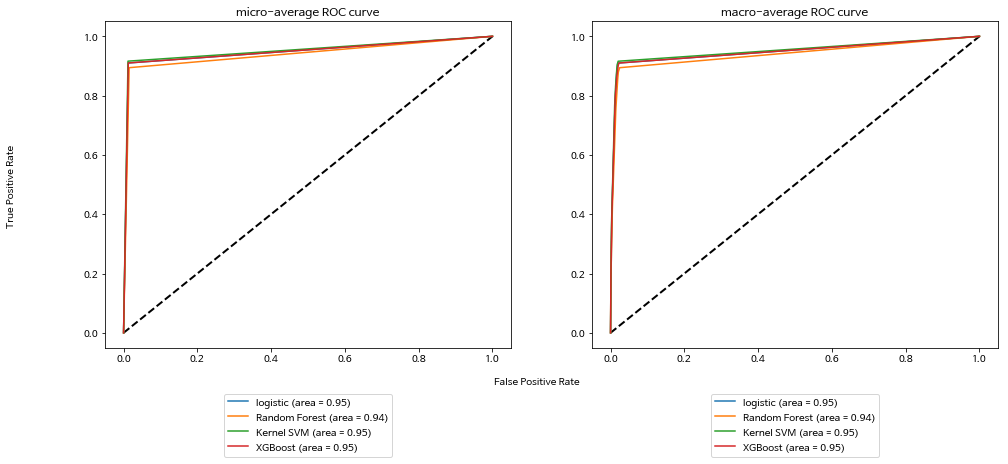

In [52]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [53]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [54]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.3948
Accuracy: 0.9193


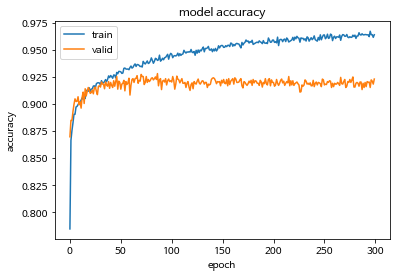

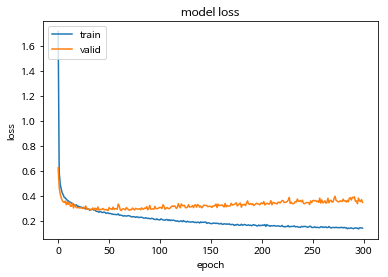

In [55]:
bm.plot_history(history)

In [56]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.6833
Accuracy: 0.9021


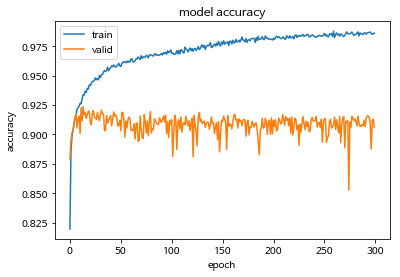

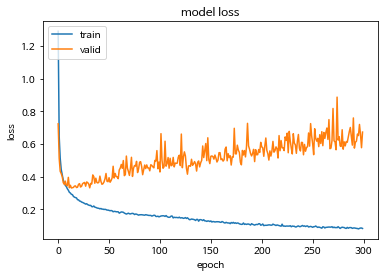

In [57]:
bm.plot_history(history)

#### model 3

In [58]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model3, tfidf, 500, train, test)
modelName = bm.Return_ModelName('fastText', model3,'ct')

 14%|█▍        | 11483/80610 [00:00<00:00, 114803.56it/s]

FastText(vocab=80610, size=500, alpha=0.025)


100%|██████████| 80610/80610 [00:01<00:00, 76207.34it/s] 
1it [00:00,  7.26it/s]

running time : 0:00:01.064530
Vectorizing Train Data


12852it [02:55, 73.35it/s]


scaling Train Data


8it [00:00, 75.03it/s]

running time : 0:02:55.706533
Vectorizing Test Data


2268it [00:29, 77.05it/s]


scaling Test Data
running time : 0:00:29.493184
total running time : 0:03:26.264247


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [59]:
%%time
bm.Make_TSNE2(2, model3, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 76745.80it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.440s...
[t-SNE] Computed neighbors for 10000 samples in 122.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.261047
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.031700
[t-SNE] Error after 1000 iterations: 3.041542


CPU times: user 12min 14s, sys: 47.6 s, total: 13min 1s
Wall time: 10min 54s


#### 분류모델 :  Logistic Regression

In [60]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.9149029982363316
classification report
             precision    recall  f1-score   support

          0       0.90      0.95      0.93       281
          1       0.88      0.85      0.86       272
          2       0.87      0.82      0.84       289
          3       0.88      0.89      0.88       271
          4       0.88      0.89      0.89       281
          5       0.99      0.99      0.99       282
          6       0.98      0.98      0.98       292
          7       0.93      0.95      0.94       300

avg / total       0.91      0.91      0.91      2268

CPU times: user 37.1 s, sys: 202 ms, total: 37.3 s
Wall time: 37.5 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

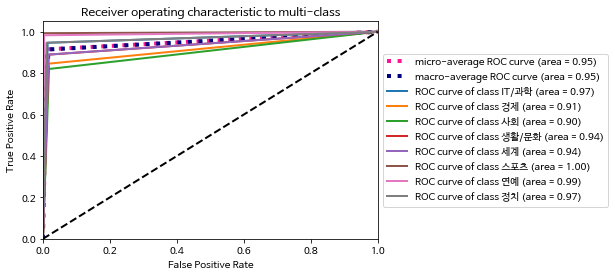

In [61]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

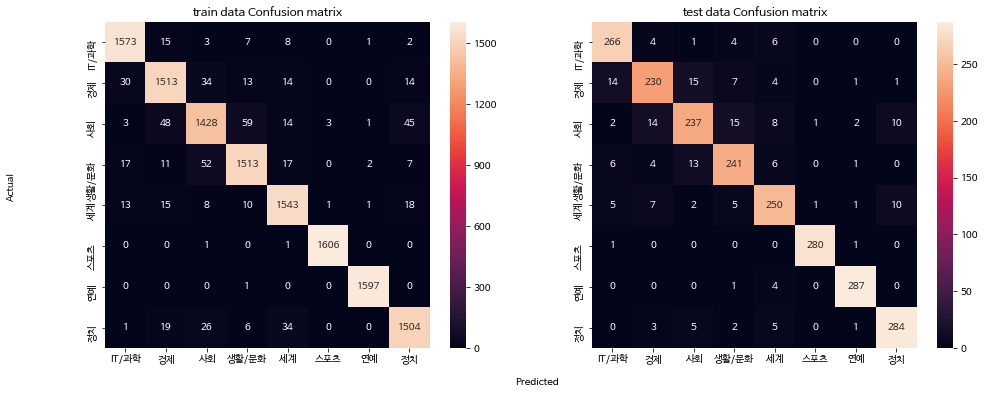

In [62]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [63]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8972663139329806
classification report
             precision    recall  f1-score   support

          0       0.88      0.95      0.91       281
          1       0.82      0.83      0.83       272
          2       0.86      0.82      0.84       289
          3       0.87      0.87      0.87       271
          4       0.89      0.81      0.85       281
          5       0.99      0.98      0.99       282
          6       0.96      0.98      0.97       292
          7       0.90      0.93      0.92       300

avg / total       0.90      0.90      0.90      2268

CPU times: user 32.4 s, sys: 206 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

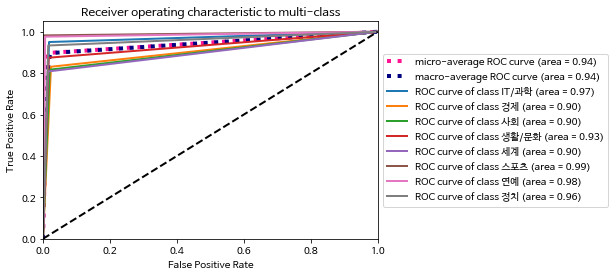

In [64]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

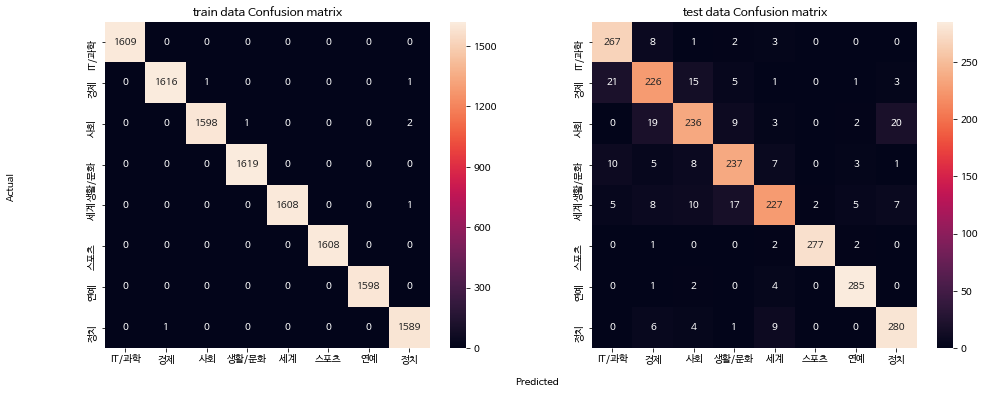

In [65]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [66]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9246031746031746
classification report
             precision    recall  f1-score   support

          0       0.91      0.98      0.94       281
          1       0.88      0.85      0.86       272
          2       0.88      0.84      0.86       289
          3       0.89      0.91      0.90       271
          4       0.93      0.88      0.91       281
          5       0.99      1.00      0.99       282
          6       0.99      0.97      0.98       292
          7       0.93      0.96      0.94       300

avg / total       0.92      0.92      0.92      2268

CPU times: user 44.8 s, sys: 127 ms, total: 44.9 s
Wall time: 45 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

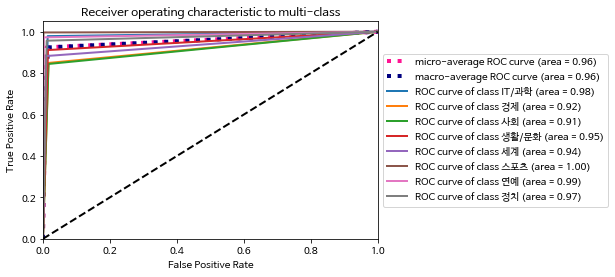

In [67]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

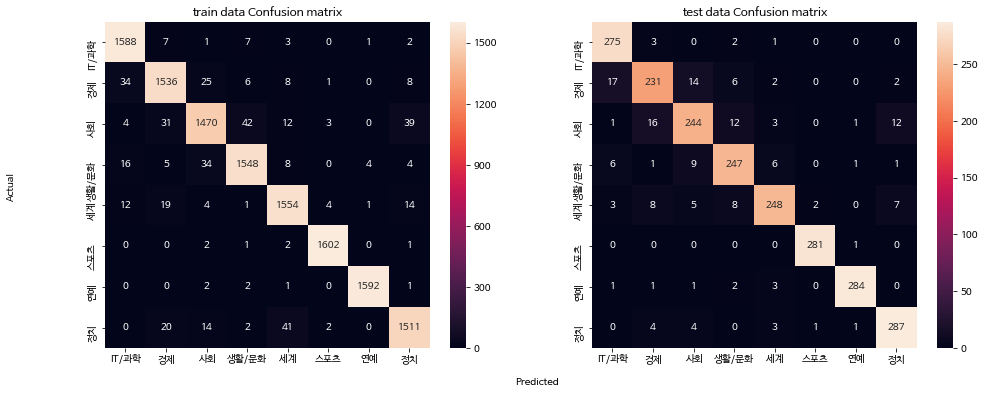

In [68]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [69]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 48.5 ms, sys: 32.2 ms, total: 80.8 ms
Wall time: 77.8 ms


In [70]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.68492	eval-mlogloss:1.70222
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.43398	eval-mlogloss:1.46347
[2]	train-mlogloss:1.24882	eval-mlogloss:1.29087
[3]	train-mlogloss:1.10164	eval-mlogloss:1.15497
[4]	train-mlogloss:0.980494	eval-mlogloss:1.04502
[5]	train-mlogloss:0.880068	eval-mlogloss:0.951642
[6]	train-mlogloss:0.795037	eval-mlogloss:0.874298
[7]	train-mlogloss:0.721935	eval-mlogloss:0.807897
[8]	train-mlogloss:0.659083	eval-mlogloss:0.7499
[9]	train-mlogloss:0.604214	eval-mlogloss:0.700765
[10]	train-mlogloss:0.55474	eval-mlogloss:0.65653
[11]	train-mlogloss:0.511685	eval-mlogloss:0.619363
[12]	train-mlogloss:0.474666	eval-mlogloss:0.585262
[13]	train-mlogloss:0.440845	eval-mlogloss:0.556083
[14]	train-mlogloss:0.411234	eval-mlogloss:0.531725
[15]	train-mlogloss:0.383887	eval-mlogloss:0.509303
[16]	train-mlogloss:0.359441	eval-mloglo

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

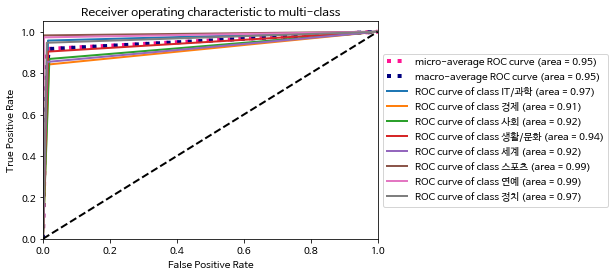

In [71]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

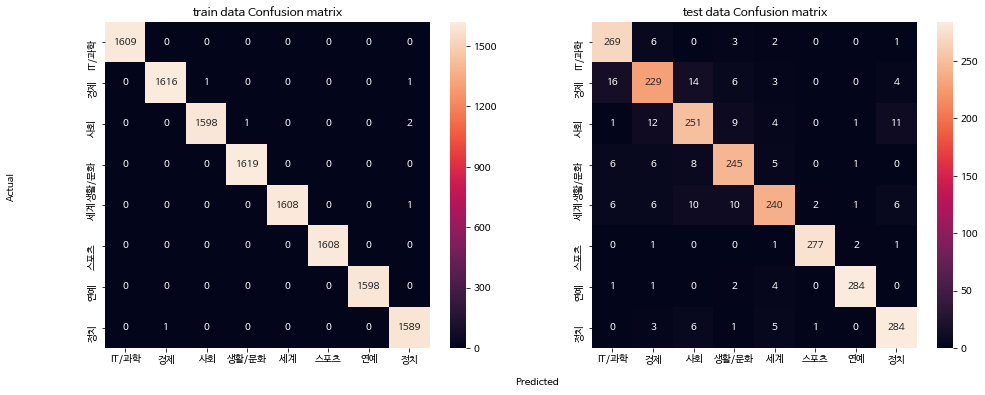

In [72]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [73]:
del classifier
del classifier2
del classifier3
del gbm

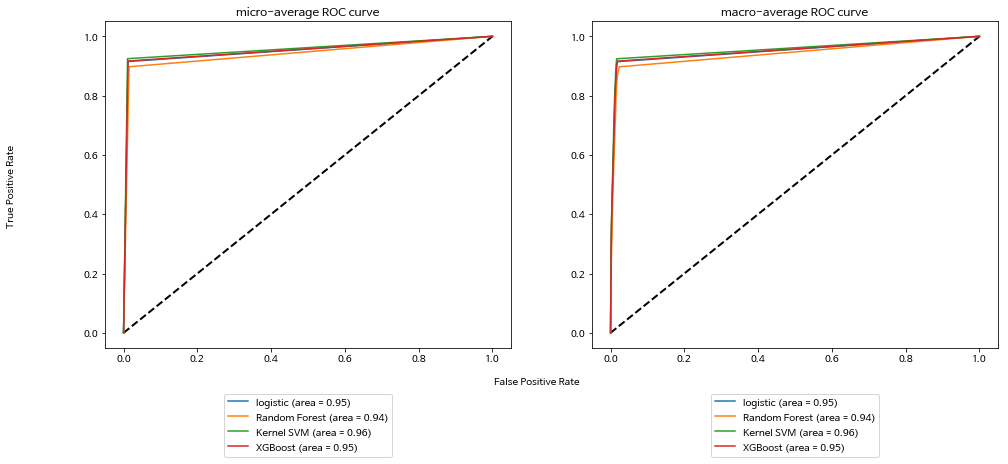

In [74]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [75]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [76]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.4424
Accuracy: 0.9171


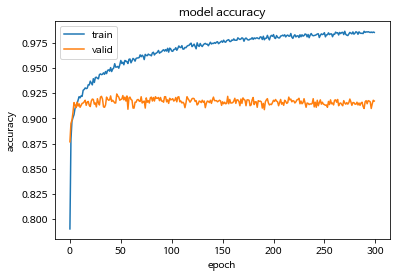

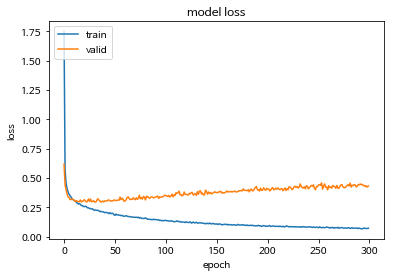

In [77]:
bm.plot_history(history)

In [78]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5354
Accuracy: 0.9171


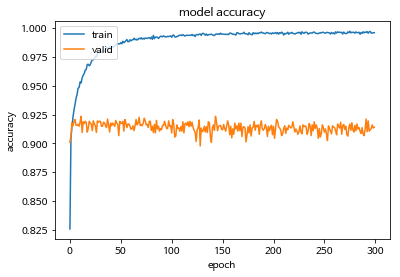

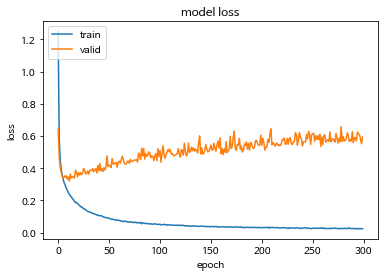

In [79]:
bm.plot_history(history)

## Tagging Mecab

> 전 단계에서 필요한 사전 데이터는 만들어 둠

### Train Data Set & Test Data Set

In [80]:
trainName = './data/pre_data/news_train_test_Data/pre_data_fastText_train_for_news_classification_by_mecab.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_fastText_test_for_news_classification_by_mecab.pickled'

In [81]:
if os.path.isfile(trainName) & os.path.isfile(testName):
    train = pickle.load(open(trainName, 'rb'))
    test = pickle.load(open(testName, 'rb'))
else:
    train, test = train_test_split(w2v_docs, test_size = 0.15)
    pickle.dump(train,open(trainName,'wb'))
    pickle.dump(test,open(testName,'wb'))

### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [82]:
tfidf = bm.Build_tfidf(train)

100%|██████████| 12852/12852 [00:00<00:00, 1145675.86it/s]


(12852, 73347)
vocab size : 73347


In [83]:
x_train = [ x.words for x in tqdm(train)] 
y_train = np.array([ x.category for x in tqdm(train)])
x_test = [ x.words for x in tqdm(test)] 
y_test = np.array([ x.category for x in tqdm(test)])

100%|██████████| 2268/2268 [00:00<00:00, 755994.71it/s]


In [84]:
train_y2, test_y2 = bm.ReMake_Outcome(y_train, y_test)

100%|██████████| 2268/2268 [00:00<00:00, 890450.39it/s]


### Load Model

In [ ]:
model1 = FastText.load(loadModelPath+'fastText_size-500_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-mecab.model')
model2 = FastText.load(loadModelPath+'fastText_size-500_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-mecab.model')
model3 = FastText.load(loadModelPath+'fastText_size-500_epoch-20_ngrams-3_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-mecab.model')

### model 1

In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model1, tfidf, 500, train, test)
modelName = bm.Return_ModelName('fastText', model1,'mecab')

 23%|██▎       | 18731/80210 [00:00<00:00, 93633.88it/s]

FastText(vocab=80210, size=500, alpha=0.025)


100%|██████████| 80210/80210 [00:00<00:00, 99767.16it/s] 
1it [00:00,  6.59it/s]

running time : 0:00:00.810337
Vectorizing Train Data


8050it [01:34, 85.00it/s]

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
bm.Make_TSNE2(2, model1, wv1, 10000)

#### 분류모델 :  Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)

### model 2

In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model2, tfidf, 500, train, test)
modelName = bm.Return_ModelName('fastText', model2,'mecab')

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
bm.Make_TSNE2(2, model2, wv1, 10000)

#### 분류모델 :  Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)

#### model 3

In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model3, tfidf, 500, train, test)
modelName = bm.Return_ModelName('fastText', model3,'mecab')

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
bm.Make_TSNE2(2, model3, wv1, 10000)

#### 분류모델 :  Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)